# Introduction

In this assignment we will implement Viterbi algorithm, Linear Equaliser, Decision Feedback Equaliser for sequence estimation in the presence of noise. The modulation scheme used is 4-PAM. As a bonus question, we will also study inter symbol interference characteristics of DFE and LE.

Each section is a question. The summaries of results and plots for all sections obtained are presented at the end. The observations also are presented at the end.

# Define functions common to all subparts

In this section, we define functions that we will be using which are common to all sections: Import libraries, define channel coefficients, random sequence generator, decoding signal alphabets from received analog value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, solve_toeplitz

In [2]:
f_n = (1/np.sqrt(2))*np.array([0.8,-1,0.6])

In [3]:
def random_4pam_sequence(n_iter):
    rand1 = np.random.rand(n_iter)
    I_n = -3*(np.less(rand1,0.25*np.ones(n_iter)))+\
    -1*(np.less(rand1,0.5*np.ones(n_iter))&np.greater(rand1,0.25*np.ones(n_iter)))+\
    1*(np.less(rand1,0.75*np.ones(n_iter))&np.greater(rand1,0.5*np.ones(n_iter)))+\
    3*(np.greater(rand1,0.75*np.ones(n_iter)))
    I_n = I_n/np.sqrt(5)
    return I_n    

In [4]:
def decode_4pam(y_n):
    n_iter = len(y_n)
    I_hat_n = np.round((np.sqrt(5)/2)*y_n+1.5*np.ones(n_iter))
    I_hat_n = (2/np.sqrt(5))*(np.clip(I_hat_n,0,3)-1.5*np.ones(n_iter))
    return I_hat_n

# Estimation using Viterbi algorithm

We define functions to calculate the transition metric for a given state(2d array consisting of possible sequences), initialisation and update for Viterbi, and running the Viterbi algorithm.

In [5]:
def transition_metric(state_array,time_index,r_n,f_n):
    r_estimate = np.sum(f_n*state_array,axis=1)
    t_metric = np.abs((r_n[time_index]-r_estimate)**2)
    return t_metric

In [6]:
def sequence_to_index_4pam(seq):
    n = len(seq[0])
    s = (np.sqrt(5)*seq+3*np.ones(np.shape(seq)))/2
    pol = 4**(np.arange(n))
    index_4pam = np.sum(s*pol,axis=1)
    return index_4pam

In [7]:
def init_step_viterbi_4pam(f_n,delta):
    L = len(f_n)
    nrows = 4**(L-1)
    ncols = int(delta)
    cmetric_init = np.zeros(nrows)
    
    state_init = np.zeros((nrows,ncols))
    
    for j in range(L-1):
        chunk_size = int(4**(L-2-j))
        block_size = 4*chunk_size
        temp = np.arange(0,nrows,block_size)
        for i in range(0,nrows,block_size):
            state_init[i:i+chunk_size,j] = -3*np.ones(chunk_size)
            state_init[i+chunk_size:i+2*chunk_size,j] = -1*np.ones(chunk_size)
            state_init[i+2*chunk_size:i+3*chunk_size,j] = 1*np.ones(chunk_size)
            state_init[i+3*chunk_size:i+4*chunk_size,j] = 3*np.ones(chunk_size)       
    
    state_init*=1/np.sqrt(5)
    return state_init, cmetric_init

In [8]:
def update_step_viterbi_4pam(curr_state,cmetric,time_index,I_hat_n,f_n,r_n):
    L = len(f_n)
    nrows = len(curr_state)
    ncols = len(curr_state[0])
    counts_delta = np.zeros(4)
    count_new_array = np.zeros(nrows)
    new_state = np.zeros((nrows,ncols))
    cmetric_new = np.zeros(nrows)
    cmetric_temp = np.zeros(nrows)
    
    new_col = np.zeros(nrows)
    
    seq = curr_state[:,0:L-1]
    
    for j in range(4):
        j_val = (2*j-3)/np.sqrt(5)
        counts_delta[j] = len(np.where(curr_state[:,-1]==j_val)[0])
        
        seq_new = np.c_[j_val*np.ones(nrows),seq]
        
        tm = transition_metric(seq_new,time_index,r_n,f_n)
        cmetric_temp = cmetric+tm
        
        idx_old = sequence_to_index_4pam(seq[:,0:-1])
        
        n_unique_idx = 4**(L-2)
        
        for i in range(n_unique_idx):
            ii = np.where(idx_old==i)[0]
            i_min = np.argmin(cmetric_temp[ii])
            row_to_add = ii[i_min]
            row_new_idx = j*n_unique_idx+i
            
            cmetric_new[row_new_idx] = cmetric_temp[row_to_add]
            new_state[row_new_idx,1:] = curr_state[row_to_add,0:-1]
            new_state[row_new_idx,0] = j_val
    
    j_s = np.argmax(counts_delta)
    I_hat_n.append((2*j_s-3)/np.sqrt(5))
    
    return new_state, cmetric_new

In [9]:
def run_viterbi_4pam(f_n,delta,r_n,terminating_sequence,n_iter):
    L = len(f_n)
    curr_state, cmetric = init_step_viterbi_4pam(f_n,delta)
    I_hat_n = []
    time_index = L-1 
    
    for i in range(n_iter):
        new_state, cmetric_new = update_step_viterbi_4pam(curr_state,cmetric,time_index,I_hat_n,f_n,r_n)
        curr_state = new_state.copy()
        cmetric = cmetric_new.copy()
        time_index+=1
        
    nrows = len(curr_state)
    
    I_hat_n = np.array(I_hat_n)
    I_hat_n = I_hat_n[delta+1-L:]
    
    
    for i in range(nrows):
        if(np.sum(np.abs(curr_state[i,0:L-1]-terminating_sequence))==0):
            I_hat_n = np.concatenate((I_hat_n,np.flip(curr_state[i])))
    
    return I_hat_n

Calculate empirical symbol error for given random sequence with noise

In [10]:
def sym_err_viterbi(delta,f_n,I_n,terminating_sequence,sigma_v):
    n_iter = len(I_n)
    I_n = np.concatenate((I_n,np.flip(terminating_sequence)))
    r_n = np.convolve(f_n,I_n)+sigma_v*np.random.randn(len(I_n)+len(f_n)-1)
    
    I_hat_n = run_viterbi_4pam(f_n,delta,r_n,terminating_sequence,n_iter)
    
    ser = np.mean(np.not_equal(I_hat_n,I_n))
    
    return ser

In [11]:
n_iter = 10**5
delta_array = np.array([3,6,15,30])
snr = np.arange(0,18,2)
stdev = 10**(-0.5*(snr/10))
I_n = random_4pam_sequence(n_iter)

termin_seq = (1/np.sqrt(5))*np.array([3,3])

ser_matrix_viterbi = np.zeros((len(delta_array),len(snr)))

for i in range(len(delta_array)):
    for j in range(len(snr)):
        ser_matrix_viterbi[i,j] = sym_err_viterbi(delta_array[i],f_n,I_n,termin_seq,stdev[j])


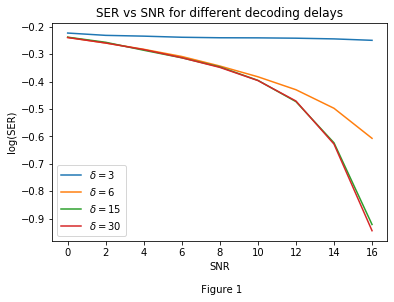

In [12]:
for i in range(len(delta_array)):
    plt.plot(snr,np.log10(ser_matrix_viterbi[i]),label=r'$\delta = $'+str(delta_array[i]))

plt.xlabel('SNR'+'\n\n Figure 1',size=10)
plt.ylabel('log(SER)')
plt.title('SER vs SNR for different decoding delays')
plt.legend()
plt.savefig('fig1.png')
plt.show()

# Estimation using Linear Equalisation

In this section, we first define functions to calculate optimal equalisation coefficient vector, which is given by:

$w_{opt} = R^{-1}p$

$R = E[r r^T], r = [r[k], r[k-1], r[k-2].....r[k-N+1]$ where N is length of equaliser

$p = E[I(k-\Delta)r]$, where $\Delta$ is decoding delay

$J_{min} = \sigma_I^2-w_{opt}^Tp$

To find optimal values of filter length and decoding delay, we calculate cost function over a range of possible values, and select the arguments corresponding to the minimum. Resolution is 1e-6 and the assumed SNR for this calculation is 10dB

In [13]:
def p_linear_eq(N,delta,f_n):
    '''
    N: Length of linear equaliser
    delta: decoding delay
    f_n: channel coefficients
    '''
    p = np.zeros(N)
    len_channel = len(f_n)
    for l in range(max(0,delta-len_channel+1),min(N,delta+1)):
        p[l] = f_n[delta-l]    
    return p

In [14]:
def R_linear_eq(N,f_n,sigma_v):
    '''
    N: Length of linear equaliser
    f_n: Channel coefficients
    sigma_v: Stdev of noise(awgn)
    Returns Toeplitz matrix
    '''
    row1 = np.zeros(N)
    row1[0] = np.sum(f_n**2)
    for i in range(1,N):
        row1[i] = np.sum(f_n[0:-i]*f_n[i:])
    R = toeplitz(row1)
    R = R+(sigma_v**2)*np.eye(N)
    return R    

In [15]:
def w_opt_linear_eq(N,delta,f_n,sigma_v):
    '''
    n: Length of linear equaliser
    delta: decoding delay
    f_n: Channel coefficients
    sigma_v: Noise stdev
    '''
    p = p_linear_eq(N,delta,f_n)
    R = R_linear_eq(N,f_n,sigma_v)
    row1 = R[0]
    w_opt = solve_toeplitz(row1,p)
    return w_opt    

In [16]:
def Jmin_linear_eq(N,delta,f_n,sigma_v):
    '''
    n: Length of linear equaliser
    delta: decoding delay
    f_n: Channel coefficients
    sigma_v: Noise stdev
    '''
    w_opt = w_opt_linear_eq(N,delta,f_n,sigma_v)
    p = p = p_linear_eq(N,delta,f_n)
    Jmin = 1-w_opt@p
    return Jmin    

In [17]:
def best_choice_linear_eq(N_max,delta_max,f_n,sigma_v):
    '''
    N_max: maximum val of N. We check Jmin for all N in 1 to N_max
    N_max: maximum val of N. We check Jmin for all N in 1 to N_max
    f_n: Channel coefficients
    sigma_v: Stdev of noise
    '''
    J = []
    N = np.arange(1,N_max+1)
    delta = np.arange(1,delta_max+1)
    
    for i in range(len(N)):
        for j in range(len(delta)):
            Jmin = Jmin_linear_eq(N[i],delta[j],f_n,sigma_v)
            J.append([N[i],delta[j],Jmin])
    
    J = np.array(J)
    J[:,-1] = np.round(J[:,-1],decimals=6)
    ii = np.argmin(J[:,-1])
    N_opt = int(J[ii,0])
    delta_opt = int(J[ii,1])
    Jmin = J[ii,-1]
    w_opt = w_opt_linear_eq(N_opt,delta_opt,f_n,sigma_v)
    return w_opt, N_opt, delta_opt, Jmin    

In [18]:
def le_symbol_err(I_n,f_n,w_opt,delta,n_iter,sigma_v):
    r_n = np.convolve(I_n,f_n)
    r_n+=sigma_v*np.random.randn(len(r_n))
    
    y_n = np.convolve(r_n,w_opt)
    y_n = y_n[delta:n_iter+delta]
    
    I_hat_n = decode_4pam(y_n)
    sym_err = np.mean(np.not_equal(I_hat_n,I_n))    
    
    return sym_err

In [19]:
#SNR = 10dB. Therefore, sigma_v = np.sqrt(0.1)
sigma_v = np.sqrt(0.1)

# Question b1: N = 3, delta = 0
N = 3
delta = 0
w_b1 = w_opt_linear_eq(N,delta,f_n,sigma_v)
Jmin_b1 = Jmin_linear_eq(N,delta,f_n,sigma_v)

print('=======================================')
print('Outputs for Q b1')
print('SNR=10dB')
print('N = 3, delta = 0')
print('\n')
print('w_opt is')
print(w_b1)
print('Jmin is')
print(Jmin_b1)

# Question b2, N = 10, delta = 0
N = 10
delta = 0
w_b2 = w_opt_linear_eq(N,delta,f_n,sigma_v)
Jmin_b2 = Jmin_linear_eq(N,delta,f_n,sigma_v)

print('=======================================')
print('Outputs for Q b2')
print('SNR=10dB')
print('N = 10, delta = 0')
print('\n')
print('w_opt is')
print(w_b2)
print('Jmin is')
print(Jmin_b2)

# Question b3, N = 10, delta = 5
N = 10
delta = 5
w_b3 = w_opt_linear_eq(N,delta,f_n,sigma_v)
Jmin_b3 = Jmin_linear_eq(N,delta,f_n,sigma_v)

print('=======================================')
print('Outputs for Q b3')
print('SNR=10dB')
print('N = 10, delta = 5')
print('\n')
print('w_opt is')
print(w_b3)
print('Jmin is')
print(Jmin_b3)

Outputs for Q b1
SNR=10dB
N = 3, delta = 0


w_opt is
[0.95869858 0.80157854 0.30092483]
Jmin is
0.4576781847283682
Outputs for Q b2
SNR=10dB
N = 10, delta = 0


w_opt is
[ 0.98162681  0.84173676  0.31296526 -0.08206659 -0.20034628 -0.13712618
 -0.03402374  0.02698237  0.03503563  0.01640834]
Jmin is
0.4447080202880155
Outputs for Q b3
SNR=10dB
N = 10, delta = 5


w_opt is
[ 0.05175672  0.18258482  0.29532074  0.17546218 -0.36100637  0.58939739
  0.64385394  0.30512781  0.01904098 -0.05445636]
Jmin is
0.33687413740034433


In [20]:
# Question b4: Best choice of N and Delta

N_max = 200
delta_max = 200
sigma_v = np.sqrt(0.1)

w_opt_le, N_opt, delta_opt, Jm = best_choice_linear_eq(N_max,delta_max,f_n,sigma_v)

print('SNR=10dB')
print('Optimal value of N is')
print(N_opt)
print('Optimal value of delta is')
print(delta_opt)
print('Jmin corresponding to these is')
print(Jm)

SNR=10dB
Optimal value of N is
30
Optimal value of delta is
15
Jmin corresponding to these is
0.331456


In [21]:
snr = np.arange(0,18,2)
stdev = 10**(-0.5*(snr/10))
n_iter = 10**5
I_n = random_4pam_sequence(n_iter)

sym_err_le = np.zeros(len(snr))
jmin_le = np.zeros(len(snr))

for i in range(len(snr)):
    w_o = w_opt_linear_eq(N_opt,delta_opt,f_n,stdev[i])
    sym_err_le[i] = le_symbol_err(I_n,f_n,w_o,delta_opt,n_iter,stdev[i])
    jmin_le[i] = Jmin_linear_eq(N_opt,delta_opt,f_n,stdev[i])

# Estimation using Decision Feedback Equalisation

In this section we calculate the optimal feed forward and feedback FIR filters to implement decision feedback equaliser. The equaliser coefficients are given by

$[w_{ff}^T, w_{fb}^T] = w_{opt}^T; w_{ff}= N_1 \times 1, w_{fb} = N_2 \times 2$

$w_{opt} = R^{-1}p$

$R = E[rr^T], r = [r[k], r[k-1],...r[k-N_1+1],I[k-\Delta-1]....I[k-\Delta-N_2]]$

The matrix R can be written in a block diagonal form:

$R = \begin{pmatrix}R_l&&S\\S^T&&I\end{pmatrix}$

Here $R_l$ is equal to the R calculated for linear equaliser, but with size $N_1$. $S_{:,i} = p_i, p_i = -E[I(k-\Delta)r_l]$. 

$p = [p_l,0,0,0,0]$. Again $p_l$ refers to that calculated for Linear equaliser.

$J_{min} = \sigma_I^2-w_{opt}^Tp$

To find optimal values of $N_1 and N_2$, we are asked to keep their sum constant(10). Again here too, we search over a range of values and find the argmin.

In [22]:
def p_dfe(N1, N2, delta, f_n):
    p = np.zeros(N1+N2)
    p[0:N1] = p_linear_eq(N1,delta,f_n)
    return p

In [23]:
def R_dfe(N1, N2, delta, f_n, sigma_v):
    
    R = np.zeros((N1+N2,N1+N2))
    R[0:N1,0:N1] = R_linear_eq(N1,f_n,sigma_v)
    R[N1:,N1:] = np.eye(N2)
    
    for i in range(1,N2+1):
        R[0:N1,N1+i-1] = -1*p_linear_eq(N1,delta+i,f_n)
        R[N1+i-1,0:N1] = R[0:N1,N1+i-1].copy()    
    return R

In [24]:
def w_opt_dfe(N1,N2,delta,f_n,sigma_v):
    R = R_dfe(N1, N2, delta, f_n, sigma_v)
    p = p_dfe(N1, N2, delta, f_n)
    w_opt = np.linalg.inv(R)@p
    return w_opt

In [25]:
def Jmin_dfe(N1,N2,delta,f_n,sigma_v):
    w = w_opt_dfe(N1,N2,delta,f_n,sigma_v)
    p = p_dfe(N1, N2, delta, f_n)
    Jmin = 1-w@p
    return Jmin

In [26]:
def best_choice_dfe(N1plusN2,delta_max,f_n,sigma_v):
    
    J = []
    N1 = np.arange(1,N1plusN2+1)
    delta = np.arange(1,delta_max+1)
    
    for i in range(len(N1)):
        for j in range(len(delta)):
            Jmin = Jmin_dfe(N1[i],N1plusN2-N1[i],delta[j],f_n,sigma_v)
            J.append([N1[i],N1plusN2-N1[i],delta[j],Jmin])
    J = np.array(J)
    ii = np.argmin(J[:,-1])
    N1_opt = int(J[ii,0])
    N2_opt = int(J[ii,1])    
    delta_opt = int(J[ii,2])
    Jmin = J[ii,-1]
    w_opt = w_opt_dfe(N1_opt,N2_opt,delta_opt,f_n,sigma_v)
    return w_opt, N1_opt, N2_opt, delta_opt, Jmin

In [27]:
#SNR = 10dB. Therefore, sigma_v = np.sqrt(0.1)
sigma_v = np.sqrt(0.1)

# Question c1
N1 = 6
N2 = 4
delta = 0
w_c1 = w_opt_dfe(N1,N2,delta,f_n,sigma_v)
Jmin_c1 = Jmin_dfe(N1,N2,delta,f_n,sigma_v)

print('=======================================')
print('Outputs for Q c1')
print('SNR=10dB')
print('N1 = 6, N2 = 4, delta = 0')
print('\n')
print('w_opt is')
print(w_c1)
print('Jmin is')
print(Jmin_c1)

# Question c1
N1 = 6
N2 = 4
delta = 3
w_c2 = w_opt_dfe(N1,N2,delta,f_n,sigma_v)
Jmin_c2 = Jmin_dfe(N1,N2,delta,f_n,sigma_v)

print('=======================================')
print('Outputs for Q c2')
print('SNR=10dB')
print('N1 = 6, N2 = 4, delta = 3')
print('\n')
print('w_opt is')
print(w_c2)
print('Jmin is')
print(Jmin_c2)

Outputs for Q c1
SNR=10dB
N1 = 6, N2 = 4, delta = 0


w_opt is
[ 1.34687006e+00 -6.23675616e-16  2.11879467e-16  1.74631017e-16
  9.67045369e-18 -3.60659639e-17 -9.52380952e-01  5.71428571e-01
 -2.88892190e-16 -6.81066652e-17]
Jmin is
0.23809523809523814
Outputs for Q c2
SNR=10dB
N1 = 6, N2 = 4, delta = 3


w_opt is
[ 6.07156583e-02 -2.99095927e-02 -3.65516413e-01  1.01585039e+00
  1.30401470e-16  1.73560879e-16 -8.73390177e-01  4.30988818e-01
 -5.06354818e-17  3.88597884e-17]
Jmin is
0.17957867415362594


In [28]:
N1plusN2 = 10
delta_max = 15
sigma_v = np.sqrt(0.1)

w_opt, N1_opt, N2_opt, delta_opt_dfe, Jm = best_choice_dfe(N1plusN2,delta_max,f_n,sigma_v)

print('SNR=10dB')
print('Optimal value of N1 is')
print(N1_opt)
print('Optimal value of N2 is')
print(N2_opt)
print('Optimal value of delta is')
print(delta_opt_dfe)
print('Jmin corresponding to these is')
print(Jm)

SNR=10dB
Optimal value of N1 is
8
Optimal value of N2 is
2
Optimal value of delta is
7
Jmin corresponding to these is
0.17372072544483863


In [29]:
def dfe_symbol_err(I_n,f_n,w_opt,N1,N2,delta,n_iter,sigma_v):
    r_n = np.convolve(I_n,f_n)+sigma_v*np.random.randn(len(I_n)+len(f_n)-1)
    
    wff = w_opt[0:N1]
    wfb = w_opt[N1:]
    
    z1_n = np.convolve(r_n,wff)
    
    I_hat_n_pre = np.zeros(N2+n_iter)
    
    for i in range(n_iter):
        z2_i = (np.flip(I_hat_n_pre[i:N2+i]))@wfb
        I_hat_n_pre[N2+i] = z1_n[delta+i]-z2_i
        I_hat_n_pre[N2+i] = np.round((np.sqrt(5)/2)*I_hat_n_pre[N2+i]+1.5)
        I_hat_n_pre[N2+i] = (2/np.sqrt(5))*(np.clip(I_hat_n_pre[N2+i],0,3)-1.5)
        
    I_hat_n = I_hat_n_pre[N2:]
    sym_err = np.mean(np.not_equal(I_hat_n,I_n))
    return sym_err

In [30]:
snr = np.arange(0,18,2)
stdev = 10**(-0.5*(snr/10))
n_iter = 10**5
I_n = random_4pam_sequence(n_iter)

sym_err_dfe = np.zeros(len(snr))
jmin_dfe = np.zeros(len(snr))

for i in range(len(snr)):
    w_o = w_opt_dfe(N1_opt,N2_opt,delta_opt_dfe,f_n,stdev[i])
    sym_err_dfe[i] = dfe_symbol_err(I_n,f_n,w_o,N1_opt,N2_opt,delta_opt_dfe,n_iter,stdev[i])

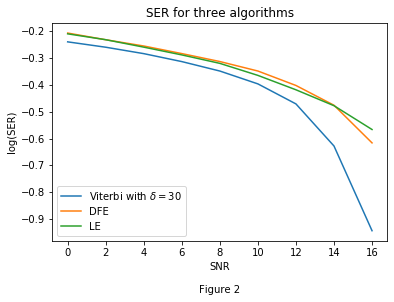

In [39]:
# Figure 2
plt.plot(snr, np.log10(ser_matrix_viterbi[-1]),label='Viterbi with '+r'$\delta=30$')
plt.plot(snr, np.log10(sym_err_dfe),label='DFE')
plt.plot(snr, np.log10(sym_err_le),label='LE')
plt.legend()
plt.xlabel('SNR'+'\n\nFigure 2',size=10)
plt.ylabel('log(SER)')
plt.title('SER for three algorithms')
plt.savefig('fig2.png')
plt.show()

# Bonus question

Computing the variance of residual inters symbol interfernece terms.

Channel coefficients are given by $f[n]$

## Linear equaliser

For linear equaliser, the input ouput relation is given by:

$\hat{I}[n-\Delta] = I[n]*f[n]*w_{opt}[n]$

Note that here we have excluded noise term, because we are only asked to calculate ISI variance

Both $f[n],w_{opt}[n]$ are FIR.

Since both of $f[n],w_{opt}[n]$ have finite L2 and L1 norm, one can apply associative property of convolution to get:

$\hat{I}[n-\Delta] = I[n]*(f[n]*w_{opt}[n])$

Let $g[n]= (f[n]*w_{opt}[n])$ be the effective channel, with length P

Simplifying the above expression, we get:

$\hat{I}[n-\Delta] = g[\Delta]I[n-\Delta]+\sum_{k=0, k\neq \Delta}^{P-1} g[k]I[n-k]$

The second term on RHS is ISI. Since $I[n]$ is zero mean, the expectation of the second term is 0 as well, making its variance simply expectation of sum of squares of $g[n],n\neq\Delta$, since I[n] has unit variance.

We calculate this in the code cell below, for best choice 10-tap LE at 10dB SNR

In [32]:
sigma_v = np.sqrt(0.1)
delta_array = np.arange(0,10+len(f_n),1)
N = 10
J = []

for j in range(len(delta_array)):
    Jmin = Jmin_linear_eq(N,delta_array[j],f_n,sigma_v)
    J.append([delta_array[j],Jmin])
    
J = np.array(J)
J[:,-1] = np.round(J[:,-1],decimals=6)
ii = np.argmin(J[:,-1])
delta_opt_le_10 = int(J[ii,0])
Jmin = J[ii,-1]
w_opt_le_10 = w_opt_linear_eq(N,delta_opt_le_10,f_n,sigma_v)

g = np.convolve(f_n,w_opt_le_10)

isi_var_le = np.sum(g**2)-g[delta_opt_le_10]**2

## Decision Feedback Equaliser

$\hat{I}[n-\Delta] = I[n]*f[n]*w_{ff}[n]-\hat{I}[n-\Delta-1]*w_{fb}[n]$

Again we are excluding the noise term because we are asked to caclulate ISI variance

Simplifying,

$\hat{I}[n-\Delta] = g[\Delta]I[n-\Delta]+\sum_{k=0}^{\Delta-1} g[k]I[n-k]+\sum_{k=0}^{N_2-1}(g[k+1+\Delta]-w_{fb}[k])I[n-\Delta-1-k]+\sum_{k=N2}^{P-1}g[k]I[n-k]$.

Here $g[n]= (f[n]*w_{ff}[n])$

This is derived assuming all previous decisions were correct

Therefore, by similar justifications as above, ISI sum variance is given by the commands in following code write cell.

In [33]:
w = w_opt
N1 = N1_opt
N2 = N2_opt
delta = delta_opt_dfe

wff = w[0:N1]
wfb = w[N1:]

g = np.convolve(wff,f_n)

temp = g.copy()
temp[delta+1:N2+delta+1] = g[delta+1:N2+delta+1]-wfb

isi_var_dfe = np.sum(temp**2)-g[delta]**2

In [34]:
# Comparison
print('Sum variance of ISI terms  for Linear Equaliser is')
print(isi_var_le)
print('Sum variance of ISI terms  for Decision Feedback Equaliser is')
print(isi_var_dfe)

Sum variance of ISI terms  for Linear Equaliser is
0.10599230999197023
Sum variance of ISI terms  for Decision Feedback Equaliser is
0.02776444708536796


We get results as expected. DFE has lesser ISI than LE, because feedback serves to cancel ISI

# Summary of all answers and plots

1. **Figure 1**

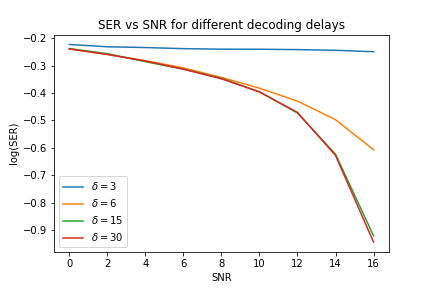

2. **Qb 1**

SNR=10dB
N = 3, delta = 0

w_opt is

[0.95869858 0.80157854 0.30092483]

Jmin is
0.4576781847283682

3. **Qb 2**

N = 10, delta = 0

w_opt is

[ 0.98162681  0.84173676  0.31296526 -0.08206659 -0.20034628 -0.13712618
 -0.03402374  0.02698237  0.03503563  0.01640834]

Jmin is

0.4447080202880155

4. **Qb 3**

SNR=10dB
N = 10, delta = 5

w_opt is

[ 0.05175672  0.18258482  0.29532074  0.17546218 -0.36100637  0.58939739
  0.64385394  0.30512781  0.01904098 -0.05445636]

Jmin is

0.33687413740034433

5. **Qb 4**

SNR=10dB

Optimal value of N is 30

Optimal value of delta is 15

Jmin corresponding to these is 0.331456

6. **Qc 1**

SNR=10dB
N1 = 6, N2 = 4, delta = 0

w_opt is

[ 1.34687006e+00 -6.23675616e-16  2.11879467e-16  1.74631017e-16
  9.67045369e-18 -3.60659639e-17 -9.52380952e-01  5.71428571e-01
 -2.88892190e-16 -6.81066652e-17]

Jmin is

0.23809523809523814

7. **Qc 2**

SNR=10dB
N1 = 6, N2 = 4, delta = 3

w_opt is

[ 6.07156583e-02 -2.99095927e-02 -3.65516413e-01  1.01585039e+00
  1.30401470e-16  1.73560879e-16 -8.73390177e-01  4.30988818e-01
 -5.06354818e-17  3.88597884e-17]

Jmin is

0.17957867415362594

8. **Qc 3**

SNR=10dB

Optimal value of N1 is 8

Optimal value of N2 is 2

Optimal value of delta is 7

Jmin corresponding to these is 0.17372072544483863

9. **Figure 2**
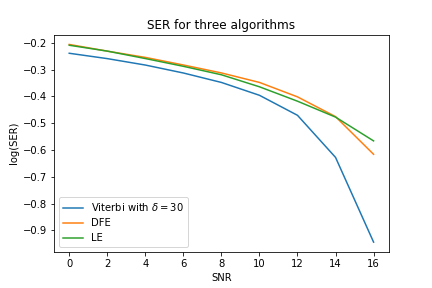

10. **Bonus question**:

Sum variance of ISI terms  for Linear Equaliser is

0.10599230999197023

Sum variance of ISI terms  for Decision Feedback Equaliser is

0.02776444708536796

# Observations and Conclusions for all the three algorithms and Bonus question

1. Question 1: Viterbi algorithm: We observe from figure 1, that the SER for decoding delay of 3 decreases very slowly. This is because the channel length itself is 3, and we are making a deicion too early, ie before the paths merge. For decoding delay of 6, the SER is bent downwards but is still greater than those for higher decoding delays. For decoding delays of 15 and 30, the curves almost coincide, becuase at decoding delay of 15 is 5 times channel length, and this indicates the sequences have merged and we are fairly close to what we would have got had we done the decoding at the end.

2. While finding optimal N and $\delta$ for linear equaliser, I observed that as N increases, cost decreases. However after a point(N=30), cost decreases by less than 1 parts per million, and so I took N=30 to be the channel equaliser length, because not only is computational complexity reduced by this choice, but we have to wait for lesser time to make the decision on the symbol. The lowest value of the cost was at N=82, but this was within 1e-7 of that of N=30, so we have not lost that much efficiency by this choice. N was searched over 1 to 200.

3. For the DFE, the optimal length for the feedback equaliser was obtained to be equal to 2. This is intuitive, because the channel length itself was 3, hence 2 terms for ISI.

4. From Figure 2 we observe that Viterbi algorithm outperforms DFE and LE by a large margin. For low SNR DFE and LE SER are roughly equal from figure 2. As an extra setp, I have plotted the comparisons for high SNR(beyond 16dB) below, and you can clearly see DFE winning out.

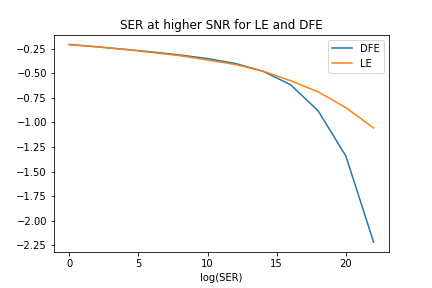

5. A possible reason for similar performances of LE and DFE at low SNR is: Since error propagates in DFE, at high SNR, the errors are also because of added noise not just ISI. DFE guards us(fairly well) against ISI, but it cannot help at high noise where error propagates.

6. For the bonus question, we calculated theoretical expressions for ISI sum variance for LE and DFE, and the observed results show DFE is a clear winner(very low ISI of around 2 percent compared to around 20 percent for LE). This is in line with our intuition that feedback helps mitigate ISI by subtracting contributions from pervious terms